In [20]:
!pip install qiskit
!pip install qiskit_aer
!pip install pylatexenc

Initial state of qubit 0:


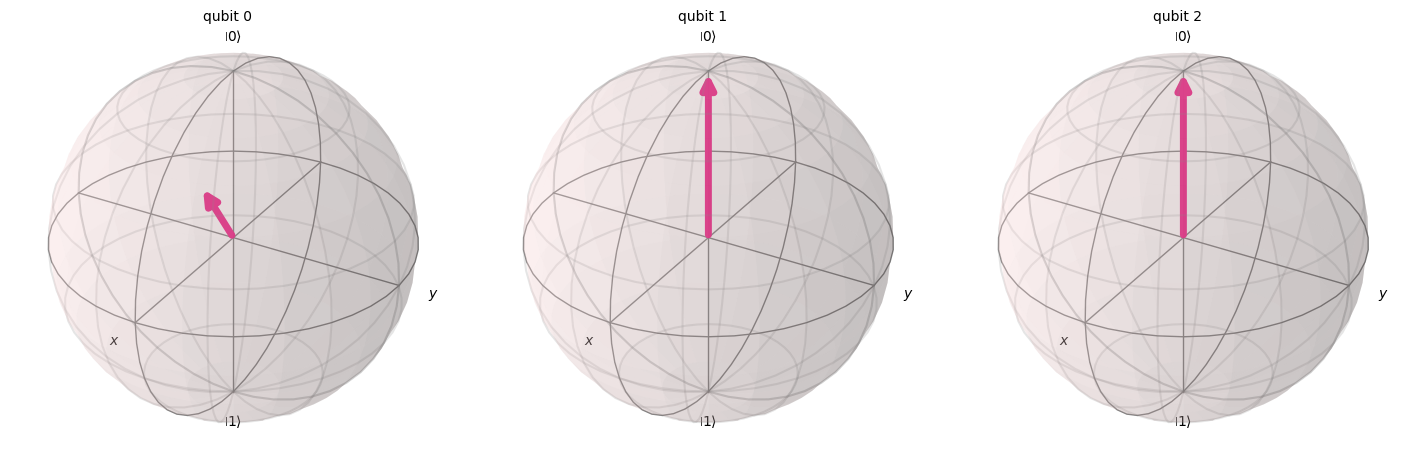

Fidelity between initial and teleported states: 1.000000

Bob’s final qubit (qubit 2) Bloch vector:


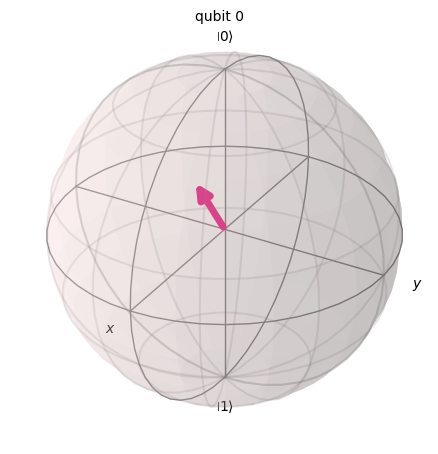

In [21]:

# Quantum Teleportation (Coherent version) – Qiskit 2.x compatible
# Works on modern qiskit-aer simulators

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, partial_trace
from qiskit.visualization import plot_bloch_multivector
import numpy as np
import matplotlib.pyplot as plt

# 1️⃣ Build the teleportation circuit
qc = QuantumCircuit(3)

# Prepare arbitrary state |ψ⟩ on qubit 0
theta, phi = 0.8, 0.3
qc.ry(theta, 0)
qc.rz(phi, 0)

# Save initial state for comparison
sv_initial = Statevector.from_instruction(qc)
print("Initial state of qubit 0:")
display(plot_bloch_multivector(sv_initial))

# Create Bell pair between qubits 1 and 2
qc.h(1)
qc.cx(1, 2)

# Bell measurement part (but coherent)
qc.cx(0, 1)
qc.h(0)

# Coherent corrections
qc.cx(1, 2)
qc.cz(0, 2)

# Save final statevector explicitly (Qiskit 2.x requires this)
qc.save_statevector()

# 2️⃣ Simulate
sim = AerSimulator()
compiled = transpile(qc, sim)
result = sim.run(compiled).result()

# Retrieve the saved statevector
sv_final = result.data(0)["statevector"]
sv_final = Statevector(sv_final)

# 3️⃣ Compare: initial vs Bob’s (qubit 2) final state
rho_bob = partial_trace(sv_final, [0, 1])
rho_init = partial_trace(sv_initial, [1, 2])

# Extract the dominant pure states (since both should be pure)
eigvals_b, eigvecs_b = np.linalg.eigh(rho_bob.data)
eigvals_i, eigvecs_i = np.linalg.eigh(rho_init.data)
bob_state = eigvecs_b[:, np.argmax(eigvals_b)]
init_state = eigvecs_i[:, np.argmax(eigvals_i)]

# Compute fidelity
fidelity = np.abs(np.vdot(init_state, bob_state)) ** 2
print(f"Fidelity between initial and teleported states: {fidelity:.6f}")

# 4️⃣ Visualize Bloch spheres (fixed)
print("\nBob’s final qubit (qubit 2) Bloch vector:")

# Convert rho_bob (DensityMatrix) → pure statevector (dominant eigenvector)
eigvals_b, eigvecs_b = np.linalg.eigh(rho_bob.data)
bob_state = eigvecs_b[:, np.argmax(eigvals_b)]  # dominant eigenvector
bob_sv = Statevector(bob_state)

display(plot_bloch_multivector(bob_sv))

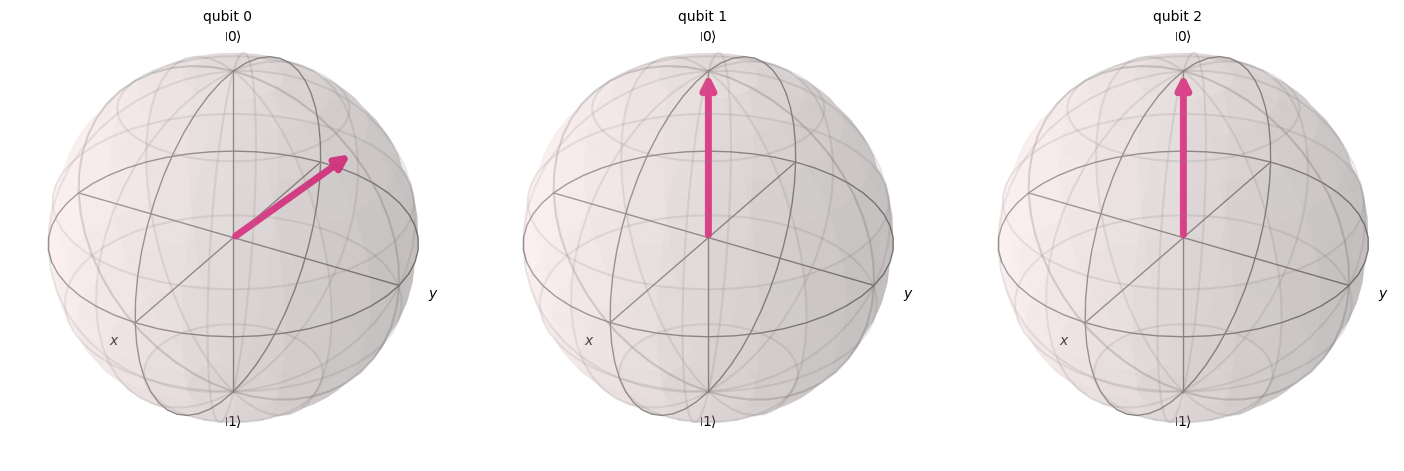

Fidelity = 1.000000


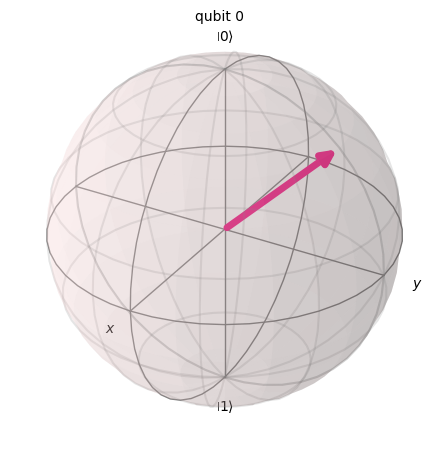

In [22]:
# Task 1 — Custom State Teleportation
!pip install qiskit qiskit_aer pylatexenc -q

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, partial_trace
from qiskit.visualization import plot_bloch_multivector
import numpy as np

# Parameters — try different values like (np.pi/4, np.pi/2)
theta, phi = np.pi/4, np.pi/2

qc = QuantumCircuit(3)

# Prepare custom state |ψ⟩
qc.ry(theta, 0)
qc.rz(phi, 0)
sv_initial = Statevector.from_instruction(qc)
display(plot_bloch_multivector(sv_initial))

# Bell pair creation
qc.h(1)
qc.cx(1, 2)

# Bell measurement
qc.cx(0, 1)
qc.h(0)

# Coherent corrections
qc.cx(1, 2)
qc.cz(0, 2)

qc.save_statevector()

# Simulate
sim = AerSimulator()
compiled = transpile(qc, sim)
result = sim.run(compiled).result()
sv_final = Statevector(result.data(0)["statevector"])

# Extract Bob’s state
rho_bob = partial_trace(sv_final, [0, 1])
rho_init = partial_trace(sv_initial, [1, 2])

# Compare fidelity
eigvals_b, eigvecs_b = np.linalg.eigh(rho_bob.data)
eigvals_i, eigvecs_i = np.linalg.eigh(rho_init.data)
bob_state = eigvecs_b[:, np.argmax(eigvals_b)]
init_state = eigvecs_i[:, np.argmax(eigvals_i)]
fidelity = np.abs(np.vdot(init_state, bob_state))**2
print(f"Fidelity = {fidelity:.6f}")
display(plot_bloch_multivector(Statevector(bob_state)))


Bloch sphere of Bob’s final qubit after conditional corrections:


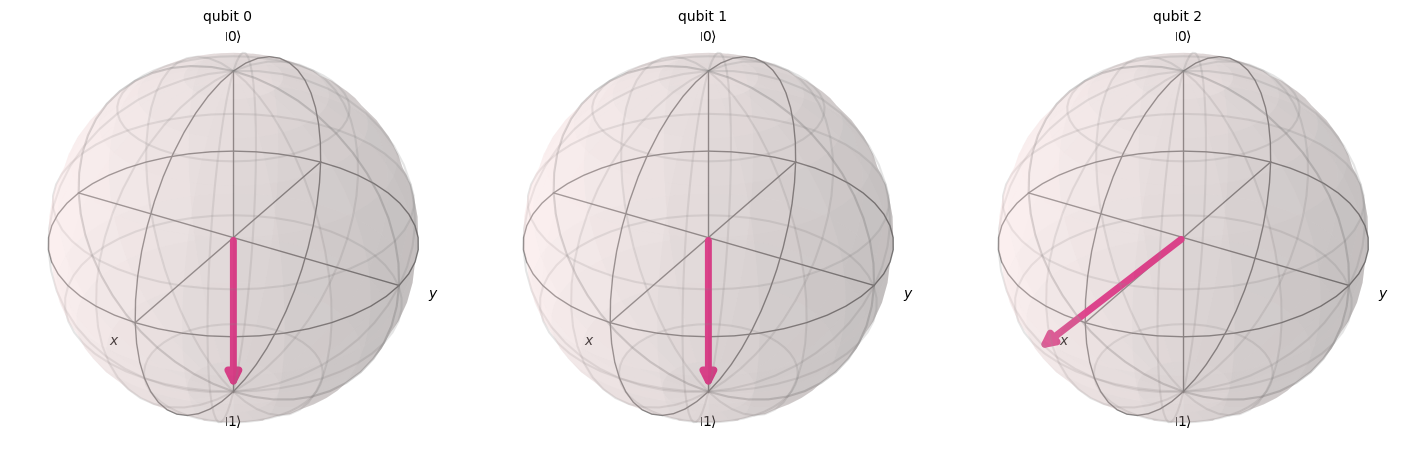

In [23]:
# Task 2 — Teleportation with measurement and classical correction
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_bloch_multivector
from qiskit.quantum_info import Statevector
import numpy as np

# Initialize 3 qubits + 2 classical bits
qc = QuantumCircuit(3, 2)

# Prepare initial state |ψ⟩ on qubit 0
theta, phi = np.pi/3, np.pi/5
qc.ry(theta, 0)
qc.rz(phi, 0)

# Create Bell pair between qubits 1 and 2
qc.h(1)
qc.cx(1, 2)

# Bell-state measurement on Alice’s side
qc.cx(0, 1)
qc.h(0)
qc.measure([0, 1], [0, 1])

# ✅ Conditional corrections using if_test() (modern Qiskit 2.x way)
with qc.if_test((0, 1)):   # if classical register == 01
    qc.x(2)
with qc.if_test((0, 2)):   # if classical register == 10
    qc.z(2)
with qc.if_test((0, 3)):   # if classical register == 11
    qc.x(2)
    qc.z(2)

# Save final state
qc.save_statevector()

# Simulate
sim = AerSimulator()
compiled = transpile(qc, sim)
result = sim.run(compiled).result()
sv_final = Statevector(result.data(0)["statevector"])

# Display Bob's final state (qubit 2)
print("Bloch sphere of Bob’s final qubit after conditional corrections:")
display(plot_bloch_multivector(sv_final))


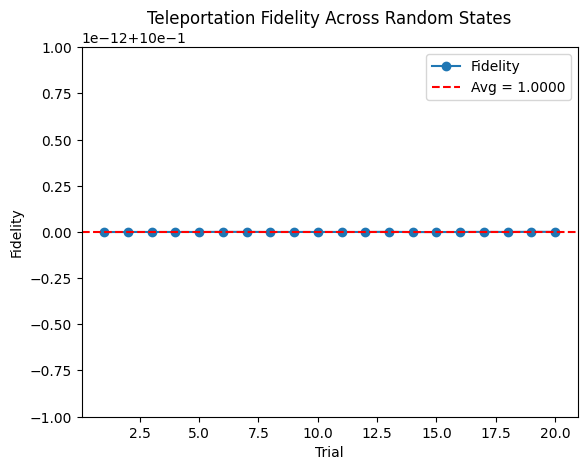

In [24]:
# Task 3 — Fidelity analysis for multiple random states
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, partial_trace
import numpy as np
import matplotlib.pyplot as plt

sim = AerSimulator()

def teleport_fidelity(theta, phi):
    qc = QuantumCircuit(3)
    qc.ry(theta, 0)
    qc.rz(phi, 0)
    sv_initial = Statevector.from_instruction(qc)
    qc.h(1)
    qc.cx(1, 2)
    qc.cx(0, 1)
    qc.h(0)
    qc.cx(1, 2)
    qc.cz(0, 2)
    qc.save_statevector()
    compiled = transpile(qc, sim)
    sv_final = Statevector(sim.run(compiled).result().data(0)["statevector"])
    rho_bob = partial_trace(sv_final, [0, 1])
    rho_init = partial_trace(sv_initial, [1, 2])
    eigvals_b, eigvecs_b = np.linalg.eigh(rho_bob.data)
    eigvals_i, eigvecs_i = np.linalg.eigh(rho_init.data)
    bob_state = eigvecs_b[:, np.argmax(eigvals_b)]
    init_state = eigvecs_i[:, np.argmax(eigvals_i)]
    return np.abs(np.vdot(init_state, bob_state))**2

# Run for 20 random states
thetas = np.random.uniform(0, np.pi, 20)
phis = np.random.uniform(0, 2*np.pi, 20)
fidelities = [teleport_fidelity(t, p) for t, p in zip(thetas, phis)]

plt.plot(range(1, 21), fidelities, 'o-', label='Fidelity')
plt.axhline(np.mean(fidelities), color='r', linestyle='--', label=f'Avg = {np.mean(fidelities):.4f}')
plt.xlabel("Trial")
plt.ylabel("Fidelity")
plt.title("Teleportation Fidelity Across Random States")
plt.legend()
plt.show()


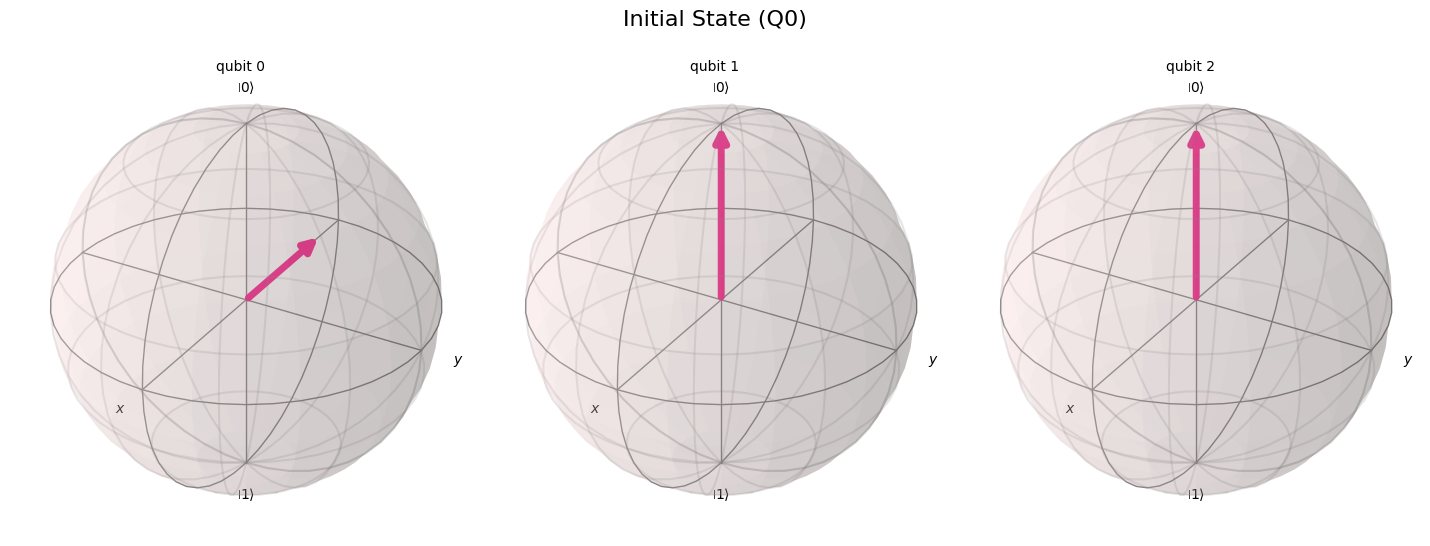

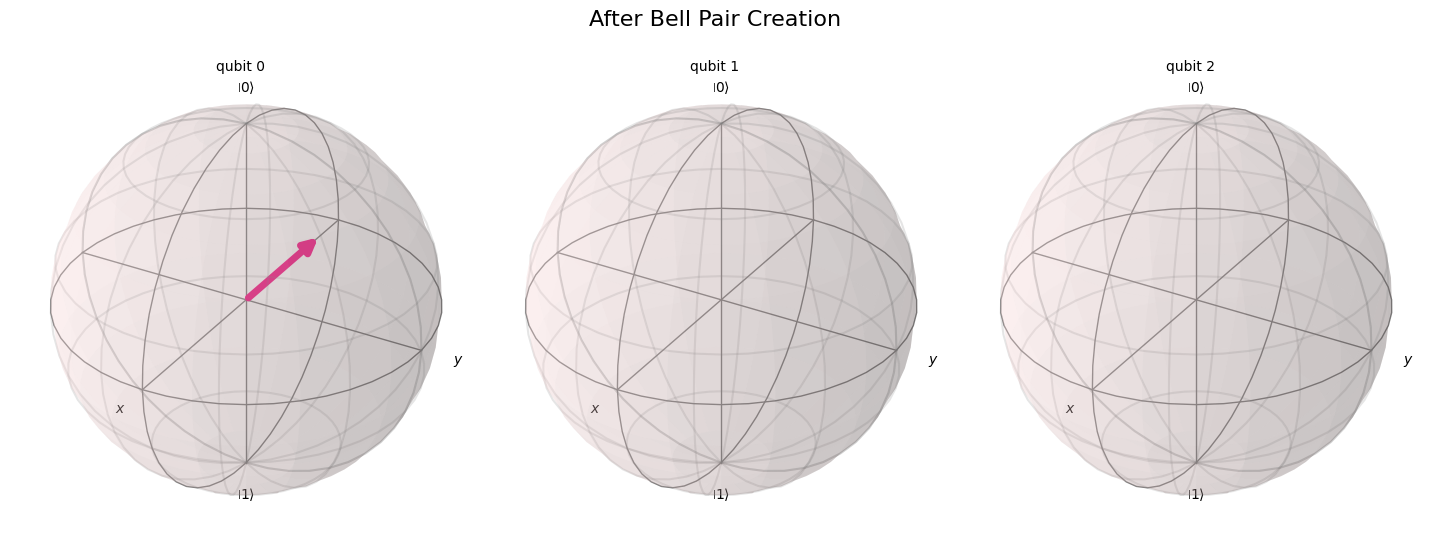

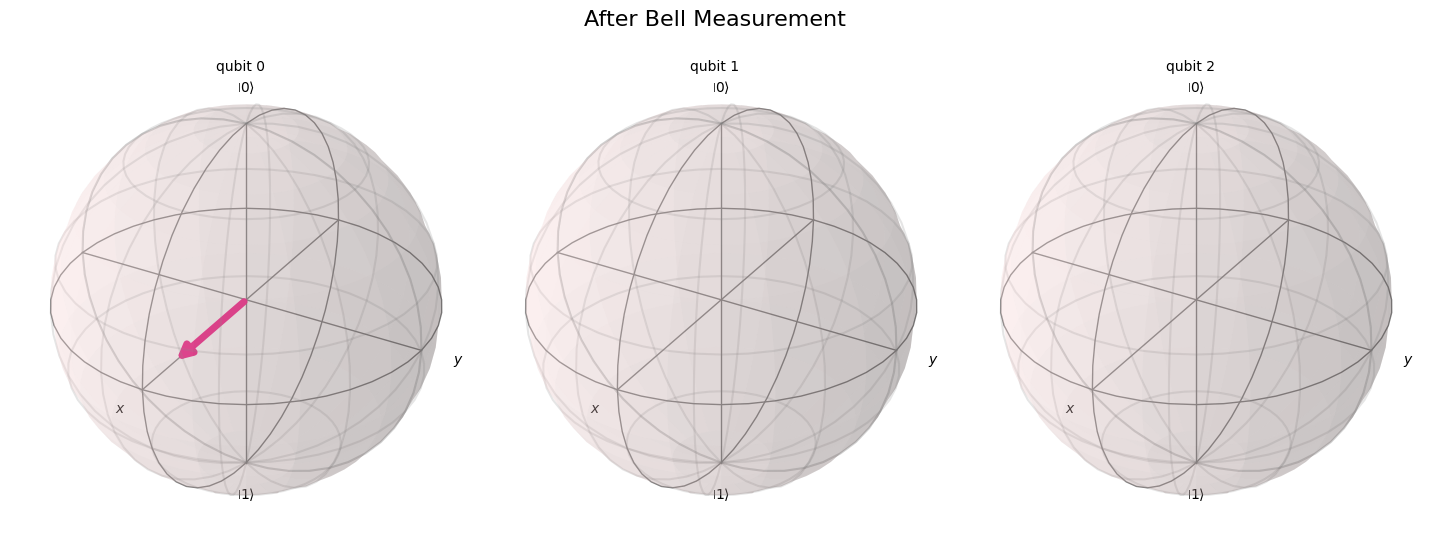

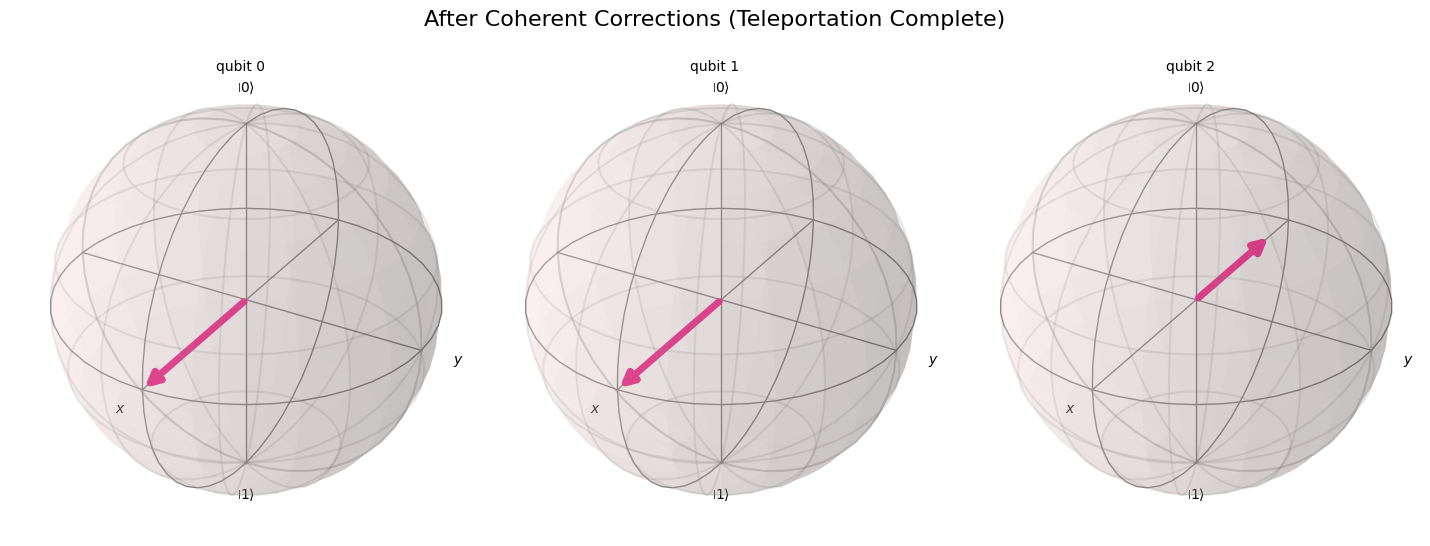

In [25]:
# Task 4 — Step-by-step visualization of teleportation
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
import numpy as np

qc = QuantumCircuit(3)
theta, phi = np.pi/4, np.pi/3
qc.ry(theta, 0)
qc.rz(phi, 0)
sv = Statevector.from_instruction(qc)
display(plot_bloch_multivector(sv, title="Initial State (Q0)"))

qc.h(1)
qc.cx(1, 2)
sv = Statevector.from_instruction(qc)
display(plot_bloch_multivector(sv, title="After Bell Pair Creation"))

qc.cx(0, 1)
qc.h(0)
sv = Statevector.from_instruction(qc)
display(plot_bloch_multivector(sv, title="After Bell Measurement"))

qc.cx(1, 2)
qc.cz(0, 2)
sv = Statevector.from_instruction(qc)
display(plot_bloch_multivector(sv, title="After Coherent Corrections (Teleportation Complete)"))


In [26]:
# Task 5 — Introduce noise and observe fidelity degradation
!pip install qiskit qiskit_aer pylatexenc -q

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error  # ✅ Correct import for Qiskit 2.x
from qiskit.quantum_info import Statevector, partial_trace
import numpy as np

# Create a simple depolarizing noise model
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.02, 1), ['rz','ry','h'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.02, 2), ['cx'])

# Use Aer simulator with noise
sim = AerSimulator(noise_model=noise_model)

# Prepare initial qubit
theta, phi = np.pi/4, np.pi/3
qc = QuantumCircuit(3)
qc.ry(theta, 0)
qc.rz(phi, 0)
sv_initial = Statevector.from_instruction(qc)

# Teleportation circuit (coherent)
qc.h(1)
qc.cx(1, 2)
qc.cx(0, 1)
qc.h(0)
qc.cx(1, 2)
qc.cz(0, 2)

# Save statevector and simulate
qc.save_statevector()
compiled = transpile(qc, sim)
result = sim.run(compiled).result()
sv_final = Statevector(result.data(0)["statevector"])

# Compute fidelity
rho_bob = partial_trace(sv_final, [0, 1])
rho_init = partial_trace(sv_initial, [1, 2])
eigvals_b, eigvecs_b = np.linalg.eigh(rho_bob.data)
eigvals_i, eigvecs_i = np.linalg.eigh(rho_init.data)
bob_state = eigvecs_b[:, np.argmax(eigvals_b)]
init_state = eigvecs_i[:, np.argmax(eigvals_i)]
fidelity = np.abs(np.vdot(init_state, bob_state))**2

print(f"Fidelity under noise = {fidelity:.6f}")


Fidelity under noise = 1.000000
